## XGBoot Model
### Classification using Pandemic Indicator(based on Temperature Average)

In [71]:
# import necessary libraries and packages
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

In [72]:
# load data
file_name = os.path.join(os.getcwd(), "final_dataset.csv")
df = pd.read_csv(file_name, header=0)

In [73]:
# split data into X and y
X = df[['Avg Temp']]
y = df['Pandemic Indicator'].values 

In [74]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Model metrics without parameters: 
- Accuracy: 58.92%
- Log loss: 14.81
- RMSE:  0.6409675583361539
- AUC-ROC: 0.62

Because the model's evaluation metrics are not sufficent, we will be using hyperparameters to improve the metrics. 

In [75]:
#hyperparameters to fine tune the model
params = {
    # Control model complexity
    "max_depth": 3,            # Limit depth of trees to prevent overfitting (lower depth = simpler model)
    "min_child_weight": 5,     # Minimum sum of weights for a leaf node to be created
    "gamma": 0.1,              # Minimum loss reduction required to make a split (higher = more conservative)
    "alpha": 0.1,            # Add L1 regularization
    "lambda": 1,             # Add L2 regularization

    # Add randomness for noise robustness
    "subsample": 0.6,          # Fraction of training samples used per boosting round
    "colsample_bytree": 0.6,   # Fraction of features used per tree

    # Learning rate and stepsize
    "eta": 0.01,               # Step size shrinkage
    "max_delta_step": 1,
    "num_boost_round" : 1000,
}

# params = {
#     "objective": "binary:logistic",
#     "max_depth": 3,
#     "min_child_weight": 5,
#     "gamma": 0.1,
#     "subsample": 0.8,
#     "colsample_bytree": 0.8,
#     "eta": 0.03,
#     "lambda": 1.0,
#     "alpha": 0.1,
#     "scale_pos_weight": len(y[y==0]) / len(y[y==1]),  # Handle class imbalance if applicable
#     "eval_metric": "logloss"
# }

In [76]:
# fit model to training data
model = xgb.XGBClassifier(**params, use_label_encoder=False)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
# Stops training if no improvement in last 10 rounds

c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "num_boost_round", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=1, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

In [77]:
# make predictions for test data
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability for the positive class
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

Accuracy: 59.26%
Root Mean Square Error:  0.6382847385042254
Log Loss: 14.684451380751431
AUC-ROC Score: 0.62


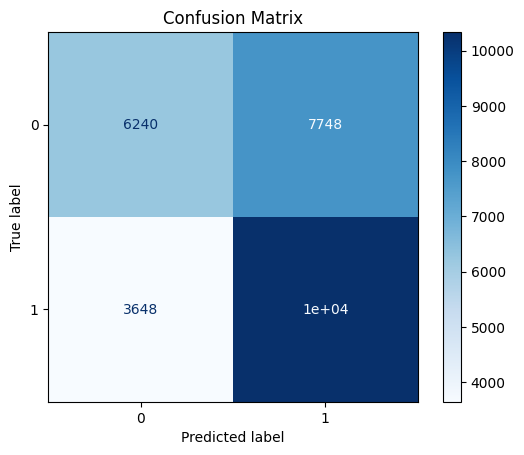

In [78]:
# evaluate predictions with accuracy, RMSE, log loss, AUC-ROC, and confusion matrix
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

rmse = np.sqrt(np.mean((y_test-y_pred)**2)) / (max(y) - min(y)).item()
print("Root Mean Square Error: ", rmse)

log_loss = log_loss(y_test, y_pred)
print("Log Loss:", log_loss)

#auc_roc score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {auc_score:.2f}")

#confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
display_matrix = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
display_matrix.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

#True positive | False positive
#False negative | True negative

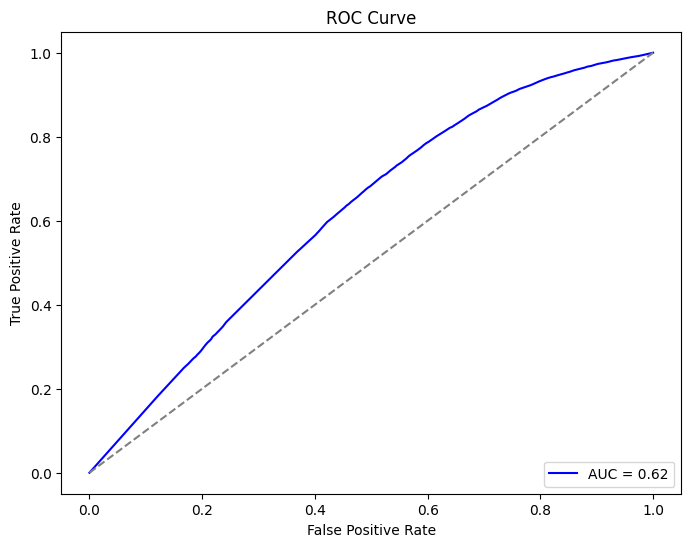

In [79]:
#plot roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

After trying different hyperparameters for the xgboost model, the model evaluation metrics were unsuccessful. As a result, we decided to tackle the most concerning evaluation metric: log loss. A log loss of about 14.8 highly suggests overfitting and the model not properly predicting the data. To improve the model's metrics, we will use model ensemble by combining xgboost with logisitic regression and a neural network. 

c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:06] WAR

Accuracy: 58.726583726583726
Log Loss: 0.67698489714947
AUC-ROC Score: 0.6076623851213757
Root Mean Square Error:  0.6424438985111173


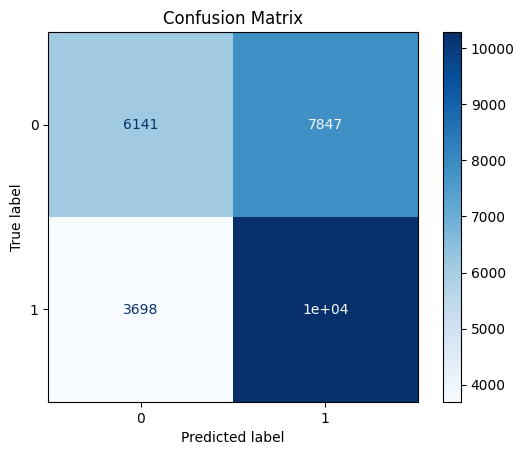

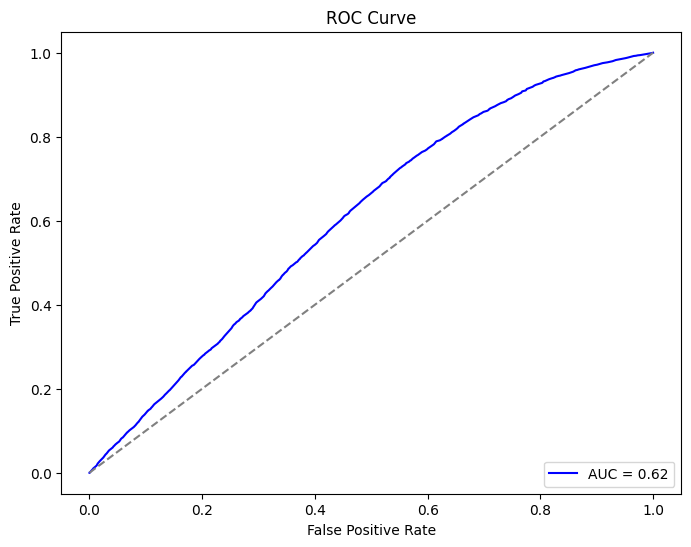

In [80]:
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss

# Define the base models
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    max_depth=3,
    min_child_weight=5,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eta=0.03,
    alpha=0.1,
    eval_metric="logloss",
    use_label_encoder=False
)

log_reg_model = LogisticRegression(max_iter=1000)

nn_model = MLPClassifier(hidden_layer_sizes=(10,), max_iter=500)

# Define the stacking ensemble
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('log_reg', log_reg_model),
        ('nn', nn_model)
    ],
    final_estimator=xgb.XGBClassifier()  # Meta model
)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Evaluate the model
y_pred_stack = stacking_model.predict(X_test)
y_pred_prob_stack = stacking_model.predict_proba(X_test)[:, 1]

# Print performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred_stack) * 100)
print("Log Loss:", log_loss(y_test, y_pred_prob_stack))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_prob_stack))

rmse = np.sqrt(np.mean((y_test-y_pred_stack)**2)) / (max(y) - min(y)).item()
print("Root Mean Square Error: ", rmse)

#confusion matrix
conf_matrix_stack = confusion_matrix(y_test, y_pred_stack)
display_matrix = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_stack)
display_matrix.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

#plot roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_stack)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
